In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

# Loading images

In [2]:
subj_dir = 'subj01'
data_dir = os.path.join('./algonauts_2023_challenge_data', subj_dir)
train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
test_img_list = os.listdir(test_img_dir)

Training images: 8857
Validation images: 984
Test images: 159


2023-02-16 17:12:58.634380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train/Val split

In [ ]:
train_img_list.sort()
test_img_list.sort()

rand_seed = 5
np.random.seed(rand_seed)
num_train = int(np.round(len(train_img_list) / 100 * 90))
idxs = np.arange(len(train_img_list))
np.random.shuffle(idxs)
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
idxs_test = np.arange(len(test_img_list))

train_img_paths = [os.path.join(train_img_dir, train_img_file) for train_img_file in train_img_list[:num_train]]
val_img_paths = [os.path.join(train_img_dir, train_img_file) for train_img_file in train_img_list[num_train:]]
test_img_paths = [os.path.join(test_img_dir, test_img_file) for test_img_file in test_img_list]
print('Training images: ' + str(len(train_img_paths)))
print('Validation images: ' + str(len(val_img_paths)))
print('Test images: ' + str(len(test_img_list)))

# SHORTING THE TRAINING IMAGES DATASET FOR TESTING
# # train_img_paths = train_img_paths[:300]
# val_img_paths = val_img_paths[:300]

# Preprocessing

In [ ]:
# Preprocessing images specific to ResNet50
def load_and_preprocess_images(images):
    images = [tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224)) for image_path in images] # they do the same resizing in the tutorial
    images = [tf.keras.preprocessing.image.img_to_array(image) for image in images] # 224*224*3
    images = [tf.keras.applications.resnet50.preprocess_input(image) for image in images] # 224*224*3 (preprocessed - what does it do exactly?)
    return images

train_images = load_and_preprocess_images(train_img_paths)
val_images = load_and_preprocess_images(val_img_paths)
test_images = load_and_preprocess_images(test_img_paths)

# Defining a model and a readout layer

In [ ]:
# Loading the model
base_model = tf.keras.applications.ResNet50(weights='imagenet')
for layer in base_model.layers:
    print(layer.name)
# Specifying the input and output layers
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


# Create datasets

In [4]:
def create_dataset(images):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.batch(300)
    return dataset

train_dataset = create_dataset(train_images)
val_dataset = create_dataset(val_images)
test_dataset = create_dataset(test_images)

# PCA

In [5]:
pca = IncrementalPCA(n_components=100, batch_size=300)

# Fit PCA to batch of datastet
for batch in tqdm(train_dataset):
    # Extract features
    features = model.predict(batch)
    # Flatten the features
    features = features.reshape(features.shape[0], -1)
    # Fit PCA to batch of features
    pca.partial_fit(features)

  0%|          | 0/30 [00:00<?, ?it/s]

(300, 224, 224, 3)
10/10 [==============================] - 66s 6s/step


  3%|▎         | 1/30 [01:23<40:08, 83.04s/it]

(300, 224, 224, 3)
10/10 [==============================] - 36s 3s/step


  7%|▋         | 2/30 [02:00<26:14, 56.21s/it]

(300, 224, 224, 3)
10/10 [==============================] - 34s 3s/step


 10%|█         | 3/30 [02:34<20:45, 46.12s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 13%|█▎        | 4/30 [03:06<17:35, 40.60s/it]

(300, 224, 224, 3)
10/10 [==============================] - 31s 3s/step


 17%|█▋        | 5/30 [03:38<15:36, 37.46s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 20%|██        | 6/30 [04:10<14:15, 35.66s/it]

(300, 224, 224, 3)
10/10 [==============================] - 31s 3s/step


 23%|██▎       | 7/30 [04:42<13:12, 34.46s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 27%|██▋       | 8/30 [05:14<12:21, 33.71s/it]

(300, 224, 224, 3)
10/10 [==============================] - 31s 3s/step


 30%|███       | 9/30 [05:46<11:35, 33.10s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 33%|███▎      | 10/30 [06:19<10:59, 32.95s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 37%|███▋      | 11/30 [06:52<10:25, 32.92s/it]

(300, 224, 224, 3)
10/10 [==============================] - 38s 4s/step


 40%|████      | 12/30 [07:31<10:25, 34.75s/it]

(300, 224, 224, 3)
10/10 [==============================] - 34s 3s/step


 43%|████▎     | 13/30 [08:06<09:53, 34.89s/it]

(300, 224, 224, 3)
10/10 [==============================] - 35s 3s/step


 47%|████▋     | 14/30 [08:41<09:18, 34.92s/it]

(300, 224, 224, 3)
10/10 [==============================] - 41s 4s/step


 50%|█████     | 15/30 [09:22<09:13, 36.93s/it]

(300, 224, 224, 3)
10/10 [==============================] - 35s 3s/step


 53%|█████▎    | 16/30 [09:58<08:29, 36.41s/it]

(300, 224, 224, 3)
10/10 [==============================] - 34s 3s/step


 57%|█████▋    | 17/30 [10:32<07:44, 35.72s/it]

(300, 224, 224, 3)
10/10 [==============================] - 39s 4s/step


 60%|██████    | 18/30 [11:12<07:24, 37.04s/it]

(300, 224, 224, 3)
10/10 [==============================] - 35s 3s/step


 63%|██████▎   | 19/30 [11:48<06:43, 36.66s/it]

(300, 224, 224, 3)
10/10 [==============================] - 37s 4s/step


 67%|██████▋   | 20/30 [12:29<06:21, 38.15s/it]

(300, 224, 224, 3)
10/10 [==============================] - 41s 4s/step


 70%|███████   | 21/30 [13:10<05:51, 39.06s/it]

(300, 224, 224, 3)
10/10 [==============================] - 44s 4s/step


 73%|███████▎  | 22/30 [13:55<05:25, 40.65s/it]

(300, 224, 224, 3)
10/10 [==============================] - 44s 4s/step


 77%|███████▋  | 23/30 [14:39<04:52, 41.82s/it]

(300, 224, 224, 3)
10/10 [==============================] - 48s 5s/step


 80%|████████  | 24/30 [15:28<04:23, 43.97s/it]

(300, 224, 224, 3)
10/10 [==============================] - 38s 4s/step


 83%|████████▎ | 25/30 [16:07<03:31, 42.38s/it]

(300, 224, 224, 3)
10/10 [==============================] - 41s 4s/step


 87%|████████▋ | 26/30 [16:48<02:48, 42.10s/it]

(300, 224, 224, 3)
10/10 [==============================] - 36s 4s/step


 90%|█████████ | 27/30 [17:25<02:01, 40.45s/it]

(300, 224, 224, 3)
10/10 [==============================] - 33s 3s/step


 93%|█████████▎| 28/30 [17:58<01:16, 38.36s/it]

(300, 224, 224, 3)
10/10 [==============================] - 32s 3s/step


 97%|█████████▋| 29/30 [18:31<00:36, 36.59s/it]

(157, 224, 224, 3)
5/5 [==============================] - 16s 3s/step


100%|██████████| 30/30 [18:47<00:00, 37.59s/it]


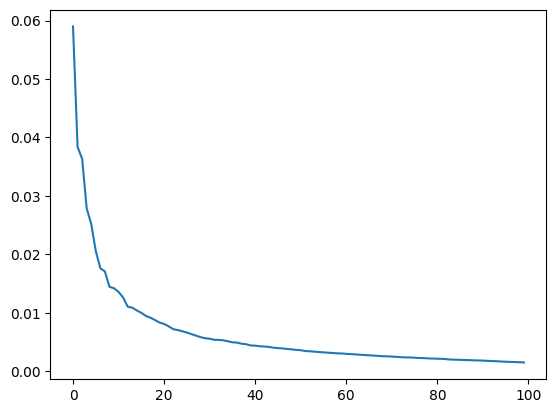

In [18]:
# plot the explained variance
plt.plot(pca.explained_variance_ratio_)

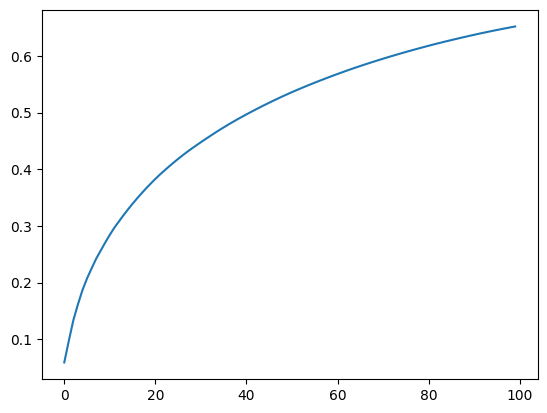

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [7]:
def extract_features(dataset, model, pca):
    features = []
    for batch in tqdm(dataset):
        ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features) # why do we need to stack the features? will .extend() work?


In [8]:
features_train = extract_features(train_dataset, model, pca)
features_val = extract_features(val_dataset, model, pca)
features_test = extract_features(test_dataset, model, pca)

  0%|          | 0/30 [00:00<?, ?it/s]

10/10 [==============================] - 35s 3s/step


  3%|▎         | 1/30 [00:36<17:25, 36.04s/it]

10/10 [==============================] - 33s 3s/step


  7%|▋         | 2/30 [01:09<16:09, 34.61s/it]

10/10 [==============================] - 40s 4s/step


 10%|█         | 3/30 [01:49<16:41, 37.11s/it]

10/10 [==============================] - 40s 4s/step


 13%|█▎        | 4/30 [02:29<16:34, 38.24s/it]

10/10 [==============================] - 39s 4s/step


 17%|█▋        | 5/30 [03:09<16:08, 38.73s/it]

10/10 [==============================] - 35s 3s/step


 20%|██        | 6/30 [03:44<15:00, 37.52s/it]

10/10 [==============================] - 34s 3s/step


 23%|██▎       | 7/30 [04:19<14:02, 36.62s/it]

10/10 [==============================] - 36s 3s/step


 27%|██▋       | 8/30 [04:55<13:22, 36.47s/it]

10/10 [==============================] - 40s 4s/step


 30%|███       | 9/30 [05:35<13:08, 37.54s/it]

10/10 [==============================] - 40s 4s/step


 33%|███▎      | 10/30 [06:15<12:48, 38.43s/it]

10/10 [==============================] - 37s 4s/step


 37%|███▋      | 11/30 [06:52<12:02, 38.00s/it]

10/10 [==============================] - 36s 3s/step


 40%|████      | 12/30 [07:28<11:12, 37.35s/it]

10/10 [==============================] - 32s 3s/step


 43%|████▎     | 13/30 [08:00<10:06, 35.67s/it]

10/10 [==============================] - 34s 3s/step


 47%|████▋     | 14/30 [08:34<09:24, 35.29s/it]

10/10 [==============================] - 39s 4s/step


 50%|█████     | 15/30 [09:13<09:05, 36.36s/it]

10/10 [==============================] - 34s 3s/step


 53%|█████▎    | 16/30 [09:47<08:19, 35.65s/it]

10/10 [==============================] - 32s 3s/step


 57%|█████▋    | 17/30 [10:20<07:31, 34.71s/it]

10/10 [==============================] - 34s 3s/step


 60%|██████    | 18/30 [10:54<06:53, 34.49s/it]

10/10 [==============================] - 38s 4s/step


 63%|██████▎   | 19/30 [11:32<06:31, 35.63s/it]

10/10 [==============================] - 38s 4s/step


 67%|██████▋   | 20/30 [12:10<06:03, 36.35s/it]

10/10 [==============================] - 35s 3s/step


 70%|███████   | 21/30 [12:46<05:25, 36.16s/it]

10/10 [==============================] - 33s 3s/step


 73%|███████▎  | 22/30 [13:19<04:43, 35.38s/it]

10/10 [==============================] - 35s 3s/step


 77%|███████▋  | 23/30 [13:54<04:06, 35.26s/it]

10/10 [==============================] - 38s 4s/step


 80%|████████  | 24/30 [14:32<03:36, 36.16s/it]

10/10 [==============================] - 37s 4s/step


 83%|████████▎ | 25/30 [15:10<03:02, 36.55s/it]

10/10 [==============================] - 38s 4s/step


 87%|████████▋ | 26/30 [15:48<02:28, 37.13s/it]

10/10 [==============================] - 33s 3s/step


 90%|█████████ | 27/30 [16:21<01:47, 35.90s/it]

10/10 [==============================] - 31s 3s/step


 93%|█████████▎| 28/30 [16:53<01:09, 34.62s/it]

10/10 [==============================] - 40s 4s/step


 97%|█████████▋| 29/30 [17:33<00:36, 36.33s/it]

5/5 [==============================] - 25s 5s/step


  0%|          | 0/4 [00:00<?, ?it/s]

10/10 [==============================] - 46s 4s/step


 25%|██▌       | 1/4 [00:49<02:29, 49.95s/it]

10/10 [==============================] - 34s 3s/step


 50%|█████     | 2/4 [01:24<01:21, 40.69s/it]

10/10 [==============================] - 41s 4s/step


 75%|███████▌  | 3/4 [02:05<00:40, 40.89s/it]

3/3 [==============================] - 12s 3s/step


  0%|          | 0/1 [00:00<?, ?it/s]

5/5 [==============================] - 21s 4s/step


100%|██████████| 1/1 [00:21<00:00, 21.45s/it]


# Handling frmi files

In [10]:
fmri_dir = os.path.join(data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


In [11]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

In [12]:
del lh_fmri, rh_fmri

# Fitting regression

In [13]:
# SHORTEN THE FMRI DATA FOR TESTING
# lh_fmri_train = lh_fmri_train[:300]
# rh_fmri_train = rh_fmri_train[:300]
# lh_fmri_val = lh_fmri_val[:300]
# rh_fmri_val = rh_fmri_val[:300]
# lh_fmri_val_pred = lh_fmri_val[:300]
# rh_fmri_val_pred = rh_fmri_val[:300]

print(lh_fmri_train.shape)
print(rh_fmri_train.shape)
print(features_train.shape)
reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(features_val)
lh_fmri_test_pred = reg_lh.predict(features_test)
rh_fmri_val_pred = reg_rh.predict(features_val)
rh_fmri_test_pred = reg_rh.predict(features_test)

(8857, 19004)
(8857, 20544)
(8857, 100)


# Calculating correlation

In [14]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

100%|██████████| 20544/20544 [00:04<00:00, 4694.40it/s]


# Visualize

/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/algonauts/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


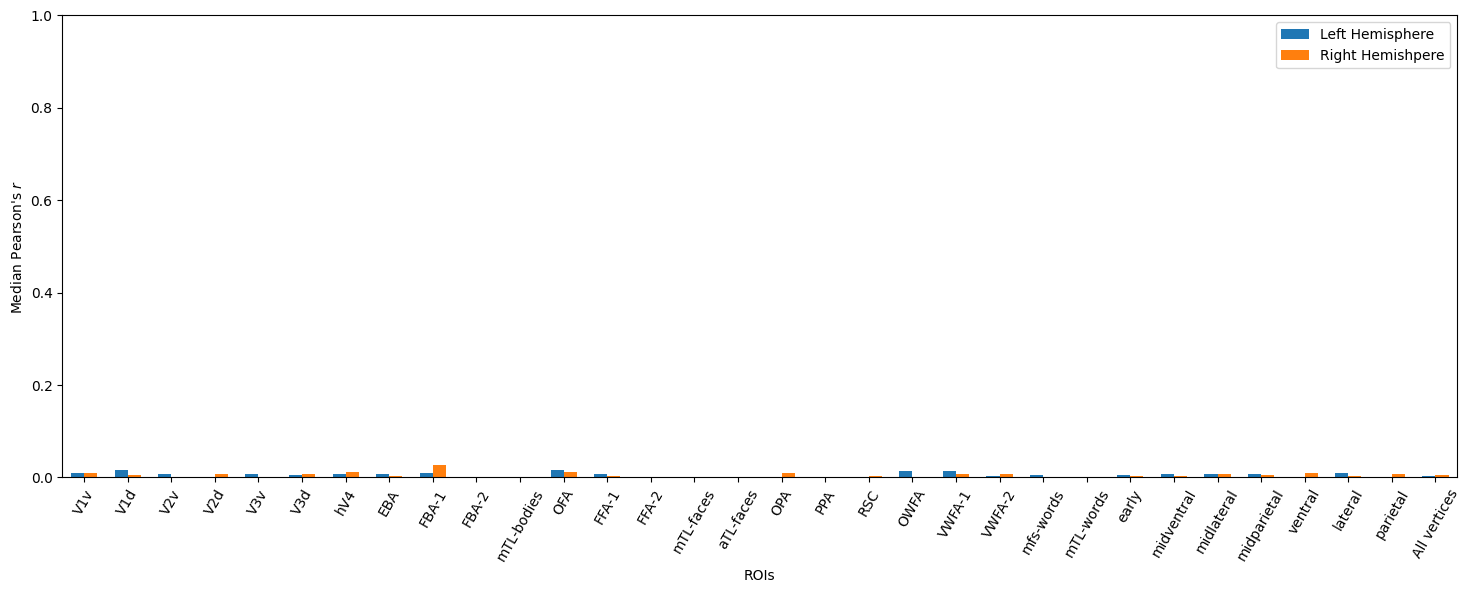

In [15]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))

# Select the correlation results vertices of each ROI
roi_names = []
lh_roi_correlation = []
rh_roi_correlation = []
for r1 in range(len(lh_challenge_rois)):
    for r2 in roi_name_maps[r1].items():
        if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
            roi_names.append(r2[1])
            lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
            rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
            lh_roi_correlation.append(lh_correlation[lh_roi_idx])
            rh_roi_correlation.append(rh_correlation[rh_roi_idx])
roi_names.append('All vertices')
lh_roi_correlation.append(lh_correlation)
rh_roi_correlation.append(rh_correlation)

# Create the plot
lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
    for r in range(len(lh_roi_correlation))]
rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
    for r in range(len(rh_roi_correlation))]
plt.figure(figsize=(18,6))
x = np.arange(len(roi_names))
width = 0.30
plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
plt.bar(x + width/2, rh_median_roi_correlation, width,
    label='Right Hemishpere')
plt.xlim(left=min(x)-.5, right=max(x)+.5)
plt.ylim(bottom=0, top=1)
plt.xlabel('ROIs')
plt.xticks(ticks=x, labels=roi_names, rotation=60)
plt.ylabel('Median Pearson\'s $r$')
plt.legend(frameon=True, loc=1)